In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6MB 7.1MB/s 
     |████████████████████████████████| 1.5MB 7.0MB/s 
     |████████████████████████████████| 194kB 9.3MB/s 
     |████████████████████████████████| 235kB 15.4MB/s 
     |████████████████████████████████| 2.2MB 14.2MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 


# Scaling Graph Neural Networks

[Previous: Graph Classification with Graph Neural Networks](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb)

So far, we have trained Graph Neural Networks for node classification tasks solely in a full-batch fashion.
In particular, that means that every node's hidden representation was computed in parallel and was available to re-use in the next layer.

However, once we want to operate on bigger graphs, this scheme is no longer feasible since memory consumption explodes.
For example, a graph with around 10 million nodes and a hidden feature dimensionality of 128 already consumes about **5GB of GPU memory for each layer**.

Hence, there has recently been some effort to let Graph Neural Networks scale to bigger graphs.
One of those approaches is known as **Cluster-GCN** ([Chiang et al. (2019)](https://arxiv.org/abs/1905.07953), which is based on pre-partitioning the graph into subgraphs on which one can operate in a mini-batch fashion.

To showcase, let's load the `PubMed` graph from the `Planetoid` node classification benchmark suite ([Yang et al. (2016)](https://arxiv.org/abs/1603.08861)):

In [ ]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('==================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===============================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!

Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(edge_index=[2, 88648], test_mask=[19717], train_mask=[19717], val_mask=[19717], x=[19717, 500], y=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.003
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


As can be seen, this graph has around 19,717 nodes.
While this number of nodes should fit into GPU memory with ease, it's nonetheless a good example to showcase how one can scale GNNs up within PyTorch Geometric.

**Cluster-GCN** ([Chiang et al. (2019)](https://arxiv.org/abs/1905.07953) works by first partioning the graph into subgraphs based on graph partitioning algorithms.
With this, GNNs are restricted to solely convolve inside their specific subgraphs, which omits the problem of **neighborhood explosion**.

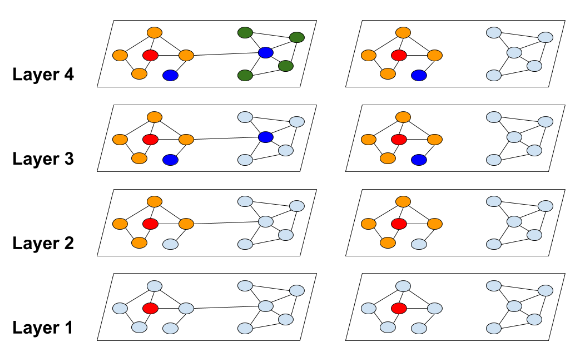

However, after the graph is partitioned, some links are removed which may limit the model's performance due to a biased estimation.
To address this issue, Cluster-GCN also **incorporates between-cluster links inside a mini-batch**, which results in the following **stochastic partitioning scheme**:

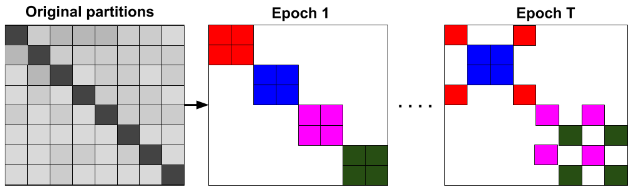

Here, colors represent the adjacency information that is maintained per batch (which is potentially different for every epoch).

PyTorch Geometric provides a **two-stage implementation** of the Cluster-GCN algorithm:
1. [**`ClusterData`**](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.ClusterData) converts a `Data` object into a dataset of subgraphs containing `num_parts` partitions.
2. Given a user-defined `batch_size`, [**`ClusterLoader`**](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.ClusterLoader) implements the stochastic partitioning scheme in order to create mini-batches.

The procedure to craft mini-batches then looks as follows:

In [ ]:
from torch_geometric.data import ClusterData, ClusterLoader

torch.manual_seed(12345)
cluster_data = ClusterData(data, num_parts=128)  # 1. Create subgraphs.
train_loader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)  # 2. Stochastic partioning scheme.

print()
total_num_nodes = 0
for step, sub_data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of nodes in the current batch: {sub_data.num_nodes}')
    print(sub_data)
    print()
    total_num_nodes += sub_data.num_nodes

print(f'Iterated over {total_num_nodes} of {data.num_nodes} nodes!')

Computing METIS partitioning...
Done!

Step 1:
Number of nodes in the current batch: 4946
Data(edge_index=[2, 15230], test_mask=[4946], train_mask=[4946], val_mask=[4946], x=[4946, 500], y=[4946])

Step 2:
Number of nodes in the current batch: 4916
Data(edge_index=[2, 18420], test_mask=[4916], train_mask=[4916], val_mask=[4916], x=[4916, 500], y=[4916])

Step 3:
Number of nodes in the current batch: 4926
Data(edge_index=[2, 16202], test_mask=[4926], train_mask=[4926], val_mask=[4926], x=[4926, 500], y=[4926])

Step 4:
Number of nodes in the current batch: 4929
Data(edge_index=[2, 17260], test_mask=[4929], train_mask=[4929], val_mask=[4929], x=[4929, 500], y=[4929])

Iterated over 19717 of 19717 nodes!


Here, we partition the initial graph into **128 partitions**, and use a **`batch_size` of 32 subgraphs** to form mini-batches (leaving us with 4 batches per epoch).
As one can see, after a single epoch, each node has been seen exactly once.

The great thing about Cluster-GCN is that it does not complicate the GNN model implementation.
Here, we can make use of the **exactly same architecture** introduced in [the second chapter of this tutorial](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX).

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 3)
)


Training of this Graph Neural Network is then quite similar to training GNNs for the task of graph classification.
Instead of operating on the graph in a full-batch fashion, we now **iterate over each mini-batch**, and **optimize each batch independently** from each other:

In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()

      for sub_data in train_loader:  # Iterate over each mini-batch.
          out = model(sub_data.x, sub_data.edge_index)  # Perform a single forward pass.
          loss = criterion(out[sub_data.train_mask], sub_data.y[sub_data.train_mask])  # Compute the loss solely based on the training nodes.
          loss.backward()  # Derive gradients.
          optimizer.step()  # Update parameters based on gradients.
          optimizer.zero_grad()  # Clear gradients.

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      
      accs = []
      for mask in [data.train_mask, data.val_mask, data.test_mask]:
          correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
          accs.append(int(correct.sum()) / int(mask.sum()))  # Derive ratio of correct predictions.
      return accs

for epoch in range(1, 51):
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train: 0.3333, Val Acc: 0.4160, Test Acc: 0.4070
Epoch: 002, Train: 0.6167, Val Acc: 0.5340, Test Acc: 0.5200
Epoch: 003, Train: 0.6500, Val Acc: 0.5300, Test Acc: 0.4980
Epoch: 004, Train: 0.6500, Val Acc: 0.5300, Test Acc: 0.4990
Epoch: 005, Train: 0.6500, Val Acc: 0.5420, Test Acc: 0.5060
Epoch: 006, Train: 0.6667, Val Acc: 0.5400, Test Acc: 0.5100
Epoch: 007, Train: 0.6833, Val Acc: 0.5440, Test Acc: 0.5150
Epoch: 008, Train: 0.7333, Val Acc: 0.5560, Test Acc: 0.5390
Epoch: 009, Train: 0.7833, Val Acc: 0.5720, Test Acc: 0.5500
Epoch: 010, Train: 0.7500, Val Acc: 0.5460, Test Acc: 0.5460
Epoch: 011, Train: 0.7500, Val Acc: 0.5580, Test Acc: 0.5500
Epoch: 012, Train: 0.7333, Val Acc: 0.5720, Test Acc: 0.5370
Epoch: 013, Train: 0.7833, Val Acc: 0.5880, Test Acc: 0.5510
Epoch: 014, Train: 0.7833, Val Acc: 0.6040, Test Acc: 0.5690
Epoch: 015, Train: 0.8167, Val Acc: 0.6240, Test Acc: 0.6100
Epoch: 016, Train: 0.8500, Val Acc: 0.6680, Test Acc: 0.6340
Epoch: 017, Train: 0.866

## Conclusion

In this chapter, you have been presented a method to scale GNNs to large graphs, which otherwise would not fit into GPU memory.

This also concludes the hands-on tutorial on **deep graph learning with PyTorch Geometric**.
If you want to learn more about GNNs or PyTorch Geometric, feel free to check out **[PyG's documentation](https://pytorch-geometric.readthedocs.io/en/latest/?badge=latest)**, **[its list of implemented methods](https://github.com/rusty1s/pytorch_geometric)** as well as **[its provided examples](https://github.com/rusty1s/pytorch_geometric/tree/master/examples)**, which cover additional topics such as **link prediction**, **graph attention**, **mesh or point cloud convolutions** and **other methods for scaling up GNNs**.

*Happy hacking!*